In [244]:
import struct
from dataclasses import dataclass
from typing import List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np

In [211]:
tmp = np.load("../test_messung_burstCnt_1.npz", allow_pickle=True)
tmp.files

['data_hex', 'data_int']

In [300]:
def del_hex_in_list(lst: list) -> list:
    return [
        "0" + ele.replace("0x", "") if len(ele) == 1 else ele.replace("0x", "")
        for ele in lst
    ]


def bytesarray_to_float(bytes_array: np.ndarray) -> float:
    bytes_array = [int(b, 16) for b in bytes_array]
    bytes_array = bytes(bytes_array)
    return struct.unpack("!f", bytes(bytes_array))[0]


def bytesarray_to_int(bytes_array: np.ndarray) -> int:
    bytes_array = bytesarray_to_byteslist(bytes_array)
    return int.from_bytes(bytes_array, "big")


def bytesarray_to_byteslist(bytes_array: np.ndarray) -> list:
    bytes_array = [int(b, 16) for b in bytes_array]
    return bytes(bytes_array)


def reshape_measurement_buffer(lst: list) -> np.ndarray:
    idx_b4 = [i for i, ele in enumerate(lst) if ele == "b4"]
    idx_b4 = np.array(idx_b4)
    step = abs(idx_b4[1] - idx_b4[0]) + 1
    return np.array(
        [lst[i : i + step] for i in range(idx_b4[0], idx_b4[-1] + step, step)],
        dtype=list,
    )[:-1]


@dataclass
class BaseSettingForEstimation:
    active_channel_groups: np.ndarray
    burst_count: int


@dataclass
class SingleFrame:
    start_tag: List[str]
    channel_group: str
    excitation_stgs: List[str]
    frequency_row: List[str]
    timestamp: int  # [ms]
    ch_1: complex
    ch_2: complex
    ch_3: complex
    ch_4: complex
    ch_5: complex
    ch_6: complex
    ch_7: complex
    ch_8: complex
    ch_9: complex
    ch_10: complex
    ch_11: complex
    ch_12: complex
    ch_13: complex
    ch_14: complex
    ch_15: complex
    ch_16: complex
    end_tag: str


def parse_single_frame(lst_ele: np.ndarray) -> SingleFrame:
    channels = {}
    enum = 0
    for i in range(11, 135, 8):
        enum += 1
        channels[f"ch_{enum}"] = complex(
            bytesarray_to_float(lst_ele[i : i + 4]),
            bytesarray_to_float(lst_ele[i + 4 : i + 8]),
        )

    excitation_stgs = np.array([ele for ele in lst_ele[3:5]])

    sgl_frm = SingleFrame(
        start_tag=lst_ele[0],
        channel_group=int(lst_ele[2]),
        excitation_stgs=excitation_stgs,
        frequency_row=lst_ele[5:7],
        timestamp=bytesarray_to_int(lst_ele[7:11]),
        **channels,
        end_tag=lst_ele[139],
    )
    return sgl_frm

In [301]:
# base_stgs_for_est = BaseSettingForEstimation(np.array([1]), 1)
base_stgs_for_est

BaseSettingForEstimation(active_channel_groups=array([1]), burst_count=1)

In [302]:
lst = del_hex_in_list(tmp["data_hex"])

In [308]:
l = reshape_measurement_buffer(lst)

In [309]:
type(l)

numpy.ndarray

In [313]:
def get_channel_group_img(reshaped_measurement_buffer: np.ndarray, channel_grout: int):
    img = np.empty((0,16))
    for i, sf in enumerate(reshaped_measurement_buffer):
        tmp_f = parse_single_frame(sf)
        if tmp_f.channel_group == channel_grout:
            tmp_f = tmp_f.__dict__
            tmp_row = np.array([tmp_f[f"ch_{ch_n}"] for ch_n in range(1, 17)])
            img = np.vstack((img, abs(tmp_row)))
    img = np.delete(np.matrix(img), 0, axis=0)
    print("Shape:", img.shape)
    return img

Shape: (32, 16)


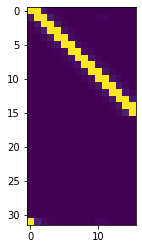

In [322]:
plt.imshow(get_channel_group_img(l, 1))